**Installation Setup:**<br>
&emsp; If you are using anaconda conda install -c chaubold opengm <br>
&emsp; If you are using Ubuntu  sudo apt-get install python-opengm <br>

## Image Denoising using Loopy Belief propagation.

In this demo ,let us go through a denoising problem that looks similar to image segmentation task. A Markov Random field is constructed to represent the neighborhood relationships in the image and we compute unary potentials for each of the nodes and binary potential for all the edges. Since this is a graph with loops, we run Loopy belief propagation to perform inference.


In this demo we get introduced to [opengm](http://hciweb2.iwr.uni-heidelberg.de/opengm/) a powerful library for PGM with many inference routines.



In [1]:
import numpy
import opengm
import scipy.io as sio

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
opengm

<module 'opengm' from '/opt/conda/envs/py27/lib/python2.7/site-packages/opengm/__init__.py'>

Let's take a sample image and add gaussian noise to it. Our task is to retrieve the orginal image from the noisy image.

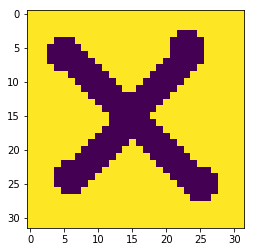

In [3]:
image = sio.loadmat("./X.mat")['X']

plt.imshow(image)

Let's distort the image by adding gaussian noise.

(32, 32)


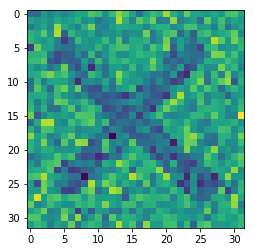

In [4]:
print(image.shape)

img = image +numpy.random.randn(image.shape[0],image.shape[1])/2
plt.imshow(img)

We take the above noisy image and construct a graph, where each pixel is connected to all its adjacent pixel. For example, a pixel in the interior of an image shares edges with top,bottom , right and left pixels around it.<br>

This is a binary image and hence every pixel takes either a value of zero or one. We use opengm library to create a graphical model.

In [5]:
img = (img - numpy.mean(img)) / numpy.std(img)

dimx=img.shape[0]
dimy=img.shape[1]

numVar=dimx*dimy
numLabels=2
beta =0.5
numberOfStates = numVar * numLabels
gm = opengm.graphicalModel([numLabels]*numVar, operator="adder")

 For every pixel we add a node in the graph and also add unary potential corresponding to it. Currently we hardcode some parameters.

In [6]:
#Adding unary function and factors
# f[0] represents the value of the factor when the node takes value 0
# f[1] represents the value of the factor when the node takes value 1

for y in range(dimy):
    for x in range(dimx):
        f=numpy.ones(2,dtype=numpy.float32)
        f[0]= numpy.exp(-1-1.3*img[x,y])  
        f[1]=1  
        fid=gm.addFunction(f)
        gm.addFactor(fid,(x*dimy+y,))

Below we create a function to get binary potential of a edge that connects two nodes. If both the nodes take the same label, then we set the potential to be zero. When they take different labels,we keep the potential to one. Thus when we run inference to find minimum energy label assignments,it favors neighbhoring pixels to take same labels.

In [7]:
# For all the binary factors (Edges) there are four possible values.
# When both the nodes have same values (both zero or both one) we set the factor to be zero
# in cases where it takes different value we let the factor be one.
# During energy minimisation, it favors neighboring labels to take same labels 

f=numpy.ones(pow(numLabels,2),dtype=numpy.float32).reshape(numLabels,numLabels)

def get_potts_value(n1,n2):
    #pot_same = -numpy.exp(1.8 + .3*1/(1+abs(n1-n2)))
    pot_same=0
    f=numpy.ones(pow(numLabels,2),dtype=numpy.float32).reshape(numLabels,numLabels)*beta
    for l in range(numLabels):
        f[l,l] = pot_same
    fid = gm.addFunction(f)
    return  fid

In [8]:
#add binary factors
for y in range(dimy):   
    for x in range(dimx):
        if(x+1<dimx):
         #vi as tuple (list and numpy array can also be used as vi's)
            fid = get_potts_value(img[x,y],img[x+1,y])
            gm.addFactor(fid,numpy.array([x*dimy+y,(x+1)*dimy+y],dtype=opengm.index_type))
        if(y+1<dimy):
         #vi as list (tuple and numpy array can also be used as vi's)
            fid = get_potts_value(img[x,y],img[x,y+1])
            gm.addFactor(fid,[x*dimy+y,x*dimy+(y+1)])

We run inference and observe the output.

In [9]:
inf=opengm.inference.BeliefPropagation(gm,parameter=opengm.InfParam(steps=10,damping=0.5,convergenceBound=0.001))
inf.infer()
argmin=inf.arg()
res=argmin.reshape(dimx,dimy)

In [10]:
res

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint64)

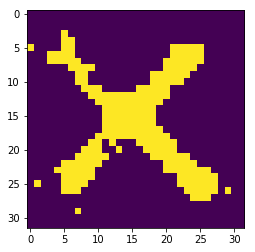

In [11]:
plt.imshow(res)

In this demo we learnt how to construct a MRF for an image. In the next module when we learn about inference in graphical models, we will revisit a similar example.